In [5]:
print('hello world')

hello world


# Importing and formating the EEG data
## Only loading 500Fs data

In [3]:
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import sys
import copy
sys.path.append('/cndd/hop006/Github/RewardReversalPorject')
from ToyQ2 import *
from matplotlib.pyplot import *


lib_path='/cndd/hop006/Github/'
data_path='/cndd/emukamel/UH2_DerAvakian/PRL_analysis/Data'
output_path='/cndd/hop006/Data/epoched_eeg/'
files=glob.glob(os.path.join(data_path,'*'))
del files[47] # one of these files is just named 1

In [4]:
mats={}
i=0
for file in files:
    mats[file]=scipy.io.loadmat(file)
    i+=1
    print(i,end=',')
mats_df=pd.DataFrame(mats)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,

# Getting just one rat
## saved rat 29, 18, 23, 30 as pickle

In [6]:
def get_ephys(date,rat_num):
    for i in mats_df.columns:
        fn=i.split('/')[-1].split()
        for j in fn:
            if j.split('_')[0]==str(date):
                if j.split('_')[1]=='Rat'+str(rat_num):
                    return mats_df.loc[:,i]
    print('doesnt exist')
    return
rat30=get_ephys(20181002,30)
rat30

__globals__                                                   []
__header__     b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...
__version__                                                  1.0
adc                                                           []
eeg            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
lfp            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
ttl            [[1.0000000000000007, 1.0000000000000007, 1.00...
tvec           [[0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012...
Name: /cndd/emukamel/UH2_DerAvakian/PRL_analysis/Data/20181002_Rat30_Fs500.mat, dtype: object

# Data summary
## the ttl vector is converted to just 0 and 1

In [7]:
class rat_summary(): # not complete
    def __init__(rat):
        self.tvecs,self.adcs,self.action1s,self.action2s,self.reward_gains,self.reward_loses={},{},{},{},{},{}
        self.low_tone=rat['ttl'][0]
        self.high_tone=rat['ttl'][1]
        self.tar=rat['ttl'][2]
        self.off_tar=rat['ttl'][3]
        self.tvec=rat['tvec'][0]
        self.adc='empty' if rat['adc'].size==0 else rat['adc'][0]


In [8]:
def rat_summary(rat): # takes a single rat's data as a pd.Series object
    tvecs,signals,low_tones,high_tones,tars,off_tars=[],[],[],[],[],[]
    low_tone=rat['ttl'][0]
    high_tone=rat['ttl'][1]
    tar=rat['ttl'][2]
    off_tar=rat['ttl'][3]
    tvec=rat['tvec'][0]
    adc='empty' if rat['adc'].size==0 else rat['adc'][0]
    lfp='empty' if sum(sum(rat['lfp']))==0 else rat['lfp']
    eeg='empty' if sum(sum(rat['eeg']))==0 else rat['eeg']
    
    signal=lfp if lfp!='empty' else eeg
    signal=np.array(signal)
    
    duration=tvec.max()
    zeros=np.where(tvec == tvec.min())[0]
    n=(zeros[1]-zeros[0])
    print('duration:',duration,'|num_recordings:',len(zeros)-1,'|n:',n)
    for i in range(1,len(zeros)): # looping thru each reset of clock
        tvecs.append(tvec[zeros[i-1]:zeros[i]])
        low_tones.append(np.round(low_tone[zeros[i-1]:zeros[i]])) # rounding the decimals off
        high_tones.append(np.round(high_tone[zeros[i-1]:zeros[i]]))
        tars.append(np.round(tar[zeros[i-1]:zeros[i]]))
        off_tars.append(np.round(off_tar[zeros[i-1]:zeros[i]]))
        signals.append(signal[:,zeros[i-1]:zeros[i]])
    return np.array(tvecs),np.array(signals),np.array(low_tones),np.array(high_tones),np.array(tars),np.array(off_tars)


In [9]:
!ls $output_path
tvecs,signals,low_tones,high_tones,tars,off_tars=rat_summary(rat30) # the low_tone and high_tone are still in raw vector form


rat18.pkl  rat23.pkl  rat29.pkl  rat30.pkl
duration: 59.998 |num_recordings: 44 |n: 30000


In [83]:
signals.shape

(44, 32, 30000)

In [84]:
tvecs.shape

(44, 30000)

# Note on the data:
## low_tone is 3, high_tone is 4, on_target is 1, off_target is 2
## epoched_eeg is returned as a 3d array, the first index is trial number, the second is channel number, and the third is time vector
## some recordings are not complete, they don't have the full 60s

In [131]:
def get_behavior(rat,eeg_length,plot=False): # each interval is around 0.002
    out=[]
    tvecs,signals,low_tones,high_tones,tars,off_tars=rat_summary(rat)
    action_log=[]
    reward_log=[]
    epoched_eeg=[]
    for i in range(len(tvecs)): #loop through each tvec
        if plot:
            plt.figure(i+1)
            ax = subplot(1,1,1)
            p1, = ax.plot(low_tones[i]*2, label="low_tone")
            p2, = ax.plot(high_tones[i], label="high_tone")
            p3, = ax.plot(tars[i], label="targets")
            p4, = ax.plot(off_tars[i],label='off_targets')
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1])

        zero_low_tones=np.where(low_tones[i] == 0)[0]
        zero_high_tones=np.where(high_tones[i] == 0)[0]
        zero_tars=np.where(tars[i] == 0)[0]
        zero_off_tars=np.where(off_tars[i] == 0)[0]
        low_tone_onset=zero_low_tones[(np.roll(zero_low_tones,1)-zero_low_tones)!=-1]
        high_tone_onset=zero_high_tones[(np.roll(zero_high_tones,1)-zero_high_tones)!=-1]
        tar_onset=zero_tars[(np.roll(zero_tars,1)-zero_tars)!=-1]
        off_tar_onset=zero_off_tars[(np.roll(zero_off_tars,1)-zero_off_tars)!=-1]
        
        zero_temp=np.zeros(tvecs[i].shape[0])
        zero_temp[tar_onset]=1
        zero_temp[off_tar_onset]=2
        for j in np.nonzero(zero_temp)[0]:
            temp=(copy.deepcopy(signals[i][:]))
            epoched_eeg.append(copy.deepcopy(temp[:,j:j+eeg_length]))
        zero_temp[low_tone_onset]=3
        zero_temp[high_tone_onset]=4
        
        log=zero_temp[np.nonzero(zero_temp)]
        action_log+=(log[log<3].tolist())
        reward_log+=(log[log>2].tolist())


#         if bool(list(reward_loss_onset)):
#             print(log)
    reward_log=np.array(reward_log)
    action_log=np.array(action_log)
    reward_log[reward_log==3]=1
    reward_log[reward_log==4]=0
    return action_log,reward_log,epoched_eeg

In [298]:
def eeg_by_label(rat,label_by_action,label_by_channel,eeg_length=300): # the label_by_action is either 1 or 2
    action_log,reward_log,epoched_eeg=get_behavior(rat30,eeg_length,plot=False)
    idx=(action_log==label_by_action)
#     out=np.empty(eeg_length)
    out=[]
    count=0
    for i,x in enumerate(idx):
        if x:
            count+=1
            temp=copy.deepcopy(epoched_eeg[i][label_by_channel])
            if temp.size!=eeg_length:
                print(count,'is not to length')
                temp.resize(eeg_length)
#             out=np.vstack((out,np.array(epoched_eeg[i][label_by_channel])))
            out.append(np.array(temp))
    return np.array(out)

# Rat30 is Low_tone for reward

In [299]:
action_log,reward_log,epoched_eeg=get_behavior(rat30,300,plot=False)

duration: 59.998 |num_recordings: 44 |n: 30000


In [315]:
tar_eeg=eeg_by_label(rat30,1,23)
off_tar_eeg=eeg_by_label(rat30,2,23)
tar_erp_raw=np.delete(tar_eeg,12,axis=0)

duration: 59.998 |num_recordings: 44 |n: 30000
13 is not to length
duration: 59.998 |num_recordings: 44 |n: 30000
30 is not to length
58 is not to length
70 is not to length


# R_AUD1 LFP ERP

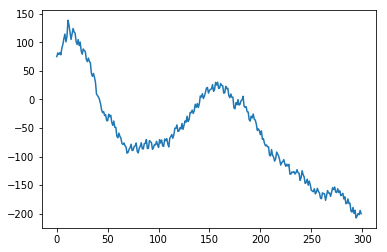

In [318]:
erp=np.mean(tar_erp_raw,axis=0)
plt.plot(erp)

# EEG processing

In [320]:
from scipy.signal import butter, sosfiltfilt, sosfreqz
from scipy.fftpack import fft, fftfreq, fftshift
# Credit for these functions goes to 'WarrenWeckesser'
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y
    
fs = 500.0     # 200 Hz sampling rate
low_cut  = 0.1; # EDIT THIS VARIABLE
high_cut = 30.0; # EDIT THIS VARIABLE
lowcut = 0.1   # 0.1 Hz is the lowest frequency we will pass
highcut = 30.0 # 30  Hz is the highest frequency we will pass.
order = 2;

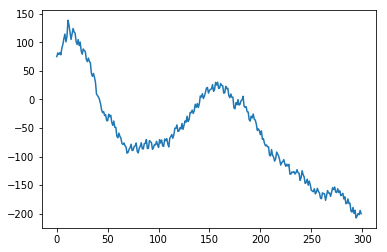

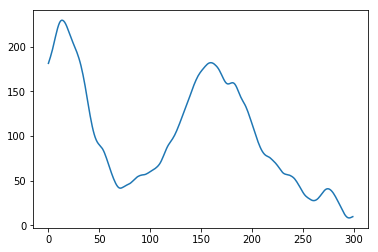

In [321]:
clean_eeg_df = butter_bandpass_filter(erp, lowcut, highcut, fs, order)
plt.figure(1)
plt.plot(erp)
plt.figure(2)
plt.plot(clean_eeg_df)

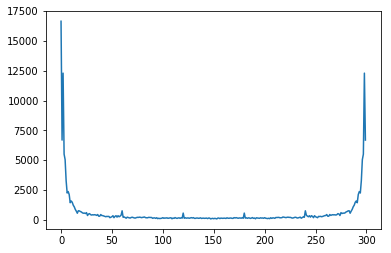

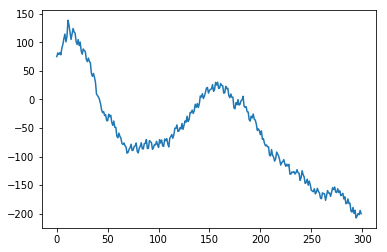

In [322]:
FFTY=np.fft.fft(erp)
plt.figure(1)
plt.plot(np.abs(FFTY))
plt.figure(2)
plt.plot(erp)

# Final Pipeline